In [1]:
from IPython.display import Image
from matplotlib import pyplot as plt
from scipy.stats import lognorm
import arviz
import numpy as np
import pandas as pd
import pystan
plt.style.use('sparse.mplstyle')

# Analysing a simple biochemical reaction system using Stan

Svetlana kindly sent me an example of a simple biochemical model to help my understanding. This notebook is my attempt to reproduce Svetlana's analysis using Stan.

The example concerns a simple linear system of chemical equations with the following structure:

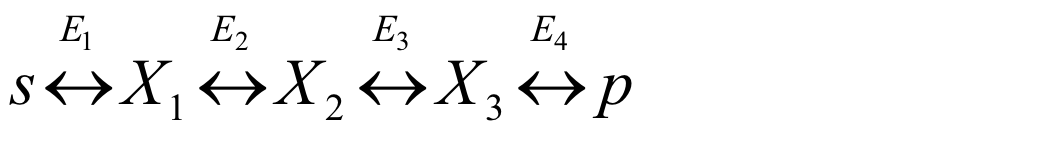

In [2]:
Image("equation.png")

In this picture $s$ and $p$ represent substrate and product concentrations, $X_1$, $X_2$ and $X_3$ represent intermediate metabolite concentrations and $E_1$, $E_2$, $E_3$ and $E_4$ represent concentrations of four different enzymes, each of which catalyses the reaction represented by its arrow.

We have a hypothetical scenario where there have been three experiments `Ex_1`, `Ex_2` and `Ex_3`. In each experiment, the system was left for a while with the concentrations of the enzymes, substrate and product being kept fixed while the concentrations of the metabolites were left to vary. Once enough time had passed to be confident that the concentrations were no longer changing, the concentrations of the metabolites were measured. In addition, we have some `Ref` values which serve to normalise our data. Here is how our results might look:

In [3]:
data = pd.read_csv('data.csv', index_col=0)
data

,E1,E2,E3,E4,s,p,X1,X2,X3,v
Ex_1,1,1,1,2,1.0,1,0.90,0.9,0.75,0.007639
Ex_2,1,2,1,1,1.0,1,0.90,1.2,1.10,0.120000
Ex_3,1,1,1,1,0.5,2,0.65,0.9,1.30,0.050000
Ref,1,1,1,1,1.0,1,0.10,0.1,0.10,0.100000


After having done the experiment, we would now like to know what we have learned about our enzymes. More specifically, suppose we know that the reactions' rates can be parameterised as follows


$$
\begin{align*}
v_1&=E_1\cdot\frac{kcat_1\cdot(S-X_1/Keq_1)}{S+Km_1+X_1/Keq_1} \\
v_2&=E_2\cdot\frac{kcat_2\cdot(X_1-X_2/Keq_2)}{X_1+Km_2+X_2/Keq_2}\cdot\frac{1}{1+X_3/KI_2} \\
v_3&=E_3\cdot\frac{kcat_3\cdot(X_2-X_3/Keq_3)}{X_2+Km_3+X_3/Keq_3} \\
v_4&=E_4\cdot\frac{kcat_4\cdot(X_3-P/Keq_4)}{X_3+Km_4+P/Keq_4} \\
\end{align*}
$$

where $kcat$, $Km$ and $Keq$ are enzyme-specific constants and $KI_2$ represents the extent to which the concentration of metabolite $X_3$ inhibits reaction 2.

Together with the graph above, these rate equations imply a system of ODEs describing how the concentrations will change over time:

$$
\begin{align*}
&\frac{dS}{dt} = -v1 \\
&\frac{dX_1}{dt} = v1-v2 \\
&\frac{dX_2}{dt} = v2-v3 \\
&\frac{dX_3}{dt} = v3-v4 \\
&\frac{dP}{dt} = v4 \\
&\end{align*}
$$

In order to learn from our experimental data, we will use the following method:

1. Come up with a plausible prior distribution for each of the system's parameters.
2. Come up with numbers describing the accuracy of the measurements
3. Combine our prior distributions with our measurement model using Bayesian inference.

The trickiest part of this approach is to say what measurements are implied by a given prior configuration. Following Svetlana's approach, I have tried generate pseudo-steady-state metabolite concentrations based on the prior parameter distributions by integrating the ODE system over a long period, starting from the reference state. This can be done within a normal Stan workflow thanks to the built in ODE solving functionality. At each MCMC iteration, the system is solved based on the current values of all parameters. See [here](https://mc-stan.org/docs/2_18/stan-users-guide/ode-solver-chapter.html) for more about ODEs in Stan.

First we compile a Stan model from a file and print its code

In [4]:
model = pystan.StanModel(file='reaction_model.stan')
print(model.model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9c50e73d096b28c774ff1e7f04b2c5a6 NOW.


functions {
#include ode_function.stan
}
data {
  int<lower=1> N_metabolite;
  int<lower=1> N_controlled;
  int<lower=1> N_experiment;
  real initial_metabolite_concentration[N_metabolite];
  real final_metabolite_concentration[N_experiment, N_metabolite];
  real controlled_concentration[N_experiment, N_controlled];
  int<lower=0,upper=1> LIKELIHOOD;
  real<lower=0> t_0;
  real<lower=0> t_steady;
  vector<lower=0>[N_metabolite] sigma;
  vector[3] enzyme_parameter_mean;
  vector<lower=0>[3] enzyme_parameter_sd;
  real K_I_mean;
  real K_I_sd;
}
parameters {
  real<lower=0> k_cat[4];
  real<lower=0> K_eq[4];
  real<lower=0> K_m[4];
  real<lower=0> K_I;
}
transformed parameters {
  real final_metabolite_concentration_hat[N_experiment, N_metabolite]; 
  for (e in 1:N_experiment){
    real theta[13] = append_array(append_array(append_array(k_cat, K_eq), K_m), {K_I});
    int x_i[0];
    final_metabolite_concentration_hat[e] =
      tail(integrate_ode_rk45(reaction_ode,
                     

The `reaction_ode` that is included at the top of the model is as follows:

In [5]:
with open("ode_function.stan", "r") as f:
    print(f.read())

real[] reaction_ode(real t, real[] y, real[] theta, real[] x_r, int[] x_i){

  real X_1 = y[1];
  real X_2 = y[2];
  real X_3 = y[3];
  
  real E_1 = x_r[1];
  real E_2 = x_r[2];
  real E_3 = x_r[3];
  real E_4 = x_r[4];
  real S = x_r[4];
  real P = x_r[5];

  real kcat_1 = theta[1];
  real kcat_2 = theta[2];
  real kcat_3 = theta[3];
  real kcat_4 = theta[4];

  real Keq_1 = theta[5];
  real Keq_2 = theta[6];
  real Keq_3 = theta[7];
  real Keq_4 = theta[8];

  real Km_1 = theta[9];
  real Km_2 = theta[10];
  real Km_3 = theta[11];
  real Km_4 = theta[12];

  real KI_2 = theta[13];

  real v1 = E_1 * (kcat_1 * (S-X_1 / Keq_1) / (S + Km_1 + X_1 / Keq_1));
  real v2 = E_2 * (kcat_2 * ((X_1-X_2 / Keq_2) / (X_1 + Km_2 + X_2 / Keq_2)) * (1 / (1 + X_3 / KI_2)));
  real v3 = E_3 * (kcat_3 * (X_2-X_3 / Keq_3) / (X_2 + Km_3 + X_3 / Keq_3));
  real v4 = E_4 * (kcat_4 * (X_3-P / Keq_4) / (X_3 + Km_4 + P / Keq_4));
  
  real dmetdt[3];
  dmetdt[1] = v1 - v2;   // X1
  dmetdt[2] = v2 - v3;   // X

## Configure the model

Next we need to make some configuration choices.

`t0` and `t_steady` specify the length of time the ode system will be solved over. These should be long enough that we can be fairly sure the system will be in a steady state after this amount of time, but short enough to save the ode solver from having to do unnecessary calculations. I chose 50 time units based on Svetlana's example.

`sigma` represents how (in)accurate the experimental measurements (i.e. $X_1, X_2, X_3$) are - i.e. if we knew the true values of all the parameters and used them to simulate the system, we assume that the measurements tend to deviate from the simulations by about `sigma`. This is a slightly tricky idea as all potential sources of error need to be taken into account, as well as the final chemical analysis. For example, deviations in the controlled enzyme/substrate/product concentrations would also cause errors. I chose 0.1 more or less arbitrarily.

The remaining statements in the cell below configure prior distributions for the model's parameters. I chose a lognormal distribution with location parameter 0 and scale parameter 0.5 for each parameter, again based on Svetlana's example (this distribution is illustrated below).

In [6]:
# time at initial state
t_0 = 0

# time by which steady state should be reached
t_steady = 50

# how accurate were the measurments for each metabolite?
sigma = [0.1, 0.1, 0.1]

# mean and sd of log priors...
# ...enzyme parameter
enzyme_parameter_mean = [0, 0, 0]
enzyme_parameter_sd = [0.5, 0.5, 0.5] 
# ...inhibition parameter
K_I_mean = 0
K_I_sd = 0.5

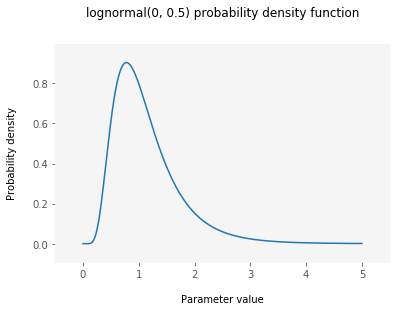

In [7]:
xx = np.linspace(0, 5, 200)

loc = 0
s = 0.5

yy = lognorm.pdf(xx, s=s, loc=loc)

f, ax = plt.subplots()
ax.plot(xx, yy)
ax.set(title=f'lognormal({loc}, {s}) probability density function',
       xlabel='Parameter value',
       ylabel='Probability density')

plt.savefig('output/lognormal.png')
plt.show()

The next cell turns our configuration and experimental data into suitable input for the Stan model.

In [8]:
initial_conditions = 'Ref'
experiments = ['Ex_1', 'Ex_2', 'Ex_3']
controlled_concentrations = ['E1', 'E2', 'E3', 'E4', 's', 'p']
enzymes = ['E1', 'E2', 'E3', 'E4']
metabolites = ['X1', 'X2', 'X3']

model_data = {
    
    # experiment results
    'N_metabolite': len(metabolites),
    'N_controlled': len(controlled_concentrations),
    'N_experiment': len(experiments),
    'initial_metabolite_concentration': data.loc[initial_conditions, metabolites],
    'final_metabolite_concentration': data.loc[experiments, metabolites],
    'controlled_concentration': data.loc[experiments, controlled_concentrations],
    
    # config
    't_0': t_0,
    't_steady': t_steady,
    'sigma': sigma,
    'enzyme_parameter_mean': enzyme_parameter_mean,
    'enzyme_parameter_sd': enzyme_parameter_sd,
    'K_I_mean': K_I_mean,
    'K_I_sd': K_I_sd
    
}

data_prior = {**model_data, **{'LIKELIHOOD': 0}}
data_posterior = {**model_data, **{'LIKELIHOOD': 1}}

print("data_posterior:")
display(data_posterior)

data_posterior:


{'N_metabolite': 3,
 'N_controlled': 6,
 'N_experiment': 3,
 'initial_metabolite_concentration': X1    0.1
 X2    0.1
 X3    0.1
 Name: Ref, dtype: float64,
 'final_metabolite_concentration':         X1   X2    X3
 Ex_1  0.90  0.9  0.75
 Ex_2  0.90  1.2  1.10
 Ex_3  0.65  0.9  1.30,
 'controlled_concentration':       E1  E2  E3  E4    s  p
 Ex_1   1   1   1   2  1.0  1
 Ex_2   1   2   1   1  1.0  1
 Ex_3   1   1   1   1  0.5  2,
 't_0': 0,
 't_steady': 50,
 'sigma': [0.1, 0.1, 0.1],
 'enzyme_parameter_mean': [0, 0, 0],
 'enzyme_parameter_sd': [0.5, 0.5, 0.5],
 'K_I_mean': 0,
 'K_I_sd': 0.5,
 'LIKELIHOOD': 1}

This cell attempts to load model results from a cache and then prints a summary.

If the cache is empty, the cell also fits the model twice (once in likelihood mode and once in prior only mode), then puts the output into a nice format (an arviz [`InferenceData`](https://arviz-devs.github.io/arviz/notebooks/XarrayforArviZ.html) object) and caches them.

**NB** If you want to try re-fitting the model, for example if you are interested in the effect of changing some configuration values, you will need to delete the file `output/stan_ode_model_output.nc` before running this cell.

In [9]:
try:
    infd = arviz.load_data('output/stan_ode_model_output.nc')
except FileNotFoundError:
    fit_prior = model.sampling(data=data_prior, iter=300, chains=3, control={'max_treedepth': 15})
    fit_posterior = model.sampling(data=data_posterior, iter=300, chains=3, control={'adapt_delta': 0.9})

    infd = arviz.from_pystan(posterior=fit_posterior,
                             posterior_predictive='final_metabolite_concentration_pred',
                             prior_predictive='final_metabolite_concentration_pred',
                             observed_data='final_metabolite_concentration',
                             prior=fit_prior,
                             coords={'experiments': experiments,
                                     'metabolites': metabolites,
                                     'enzymes': ['E1', 'E2', 'E3', 'E4']},
                             dims={'k_cat': ['enzymes'], 
                                   'K_eq': ['enzymes'],
                                   'K_m': ['enzymes'],
                                   'final_metabolite_concentration': ['experiments', 'metabolites'],
                                   'final_metabolite_concentration_pred': ['experiments', 'metabolites'],
                                   'final_metabolite_concentration_hat': ['experiments', 'metabolites']})
    infd.to_netcdf('output/stan_ode_model_output.nc')

arviz.summary(infd.posterior, var_names=['k_cat', 'K_eq', 'K_m', 'K_I'])

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
k_cat[0],0.56,0.17,0.01,0.29,0.86,378.0,1.0
k_cat[1],2.34,0.97,0.04,0.99,4.34,381.0,1.0
k_cat[2],1.92,0.84,0.04,0.88,3.80,307.0,1.0
k_cat[3],0.60,0.21,0.01,0.29,1.01,270.0,1.0
K_eq[0],2.30,0.87,0.04,0.97,3.81,339.0,1.0
K_eq[1],2.11,0.44,0.02,1.34,2.86,409.0,1.0
K_eq[2],1.51,0.24,0.01,1.10,1.97,518.0,1.0
K_eq[3],3.85,1.19,0.03,2.06,6.22,543.0,1.0
K_m[0],0.69,0.28,0.01,0.20,1.18,470.0,1.0
K_m[1],0.80,0.43,0.02,0.24,1.55,600.0,1.0


A look at the fit summary, together with the lack of diagnostic warnings in the cell above, indicates that the model has probably converged successfully.

To find out what the model learned from the data, we can look at the prior and posterior distributions of the most interesting parameters. The next cell plots them:

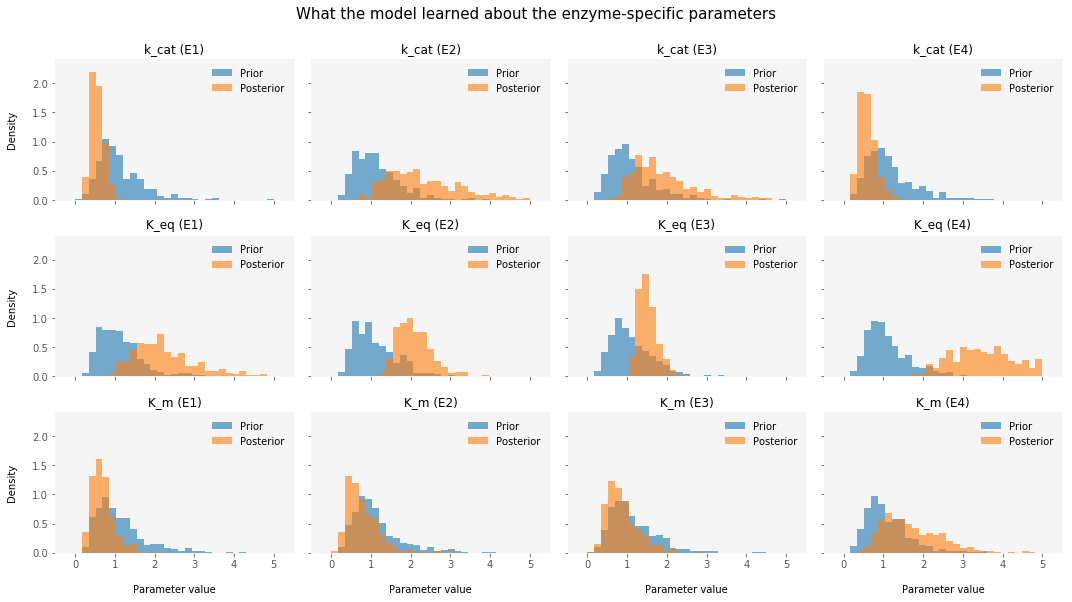

In [10]:
parameters = ['k_cat', 'K_eq', 'K_m']

bins = np.linspace(0, 5, 30)

f, axes = plt.subplots(3, 4, figsize=[15, 8], sharex=True, sharey=True)

for row, par in zip(axes, parameters):
    samples_prior = infd.prior[par].to_dataframe().unstack()[par]
    samples_posterior = infd.posterior[par].to_dataframe().unstack()[par]
    for enzyme, ax in zip(enzymes, row):
        h_prior = ax.hist(samples_prior[enzyme], alpha=0.6, bins=bins, density=True, label='Prior')
        h_posterior = ax.hist(samples_posterior[enzyme], alpha=0.6, bins=bins, density=True, label='Posterior')
        if ax == row[0]:
            ax.set_ylabel('Density')
        if ax in axes[-1]:
            ax.set_xlabel('Parameter value')
        ax.set_title(f'{par} ({enzyme})', y=0.85)
        leg = ax.legend(frameon=False)

f.suptitle("What the model learned about the enzyme-specific parameters", fontsize=15, y=1.04)
plt.tight_layout()
plt.savefig('output/enzyme_parameter_histograms.png')

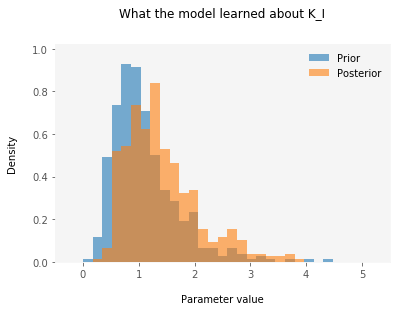

In [11]:
bins = np.linspace(0, 5, 30)
par = 'K_I'
samples_prior = infd.prior[par].to_dataframe()[par]
samples_posterior = infd.posterior[par].to_dataframe()[par]

f, ax = plt.subplots()
h_prior = ax.hist(samples_prior, alpha=0.6, bins=bins, density=True, label='Prior')
h_posterior = ax.hist(samples_posterior, alpha=0.6, bins=bins, density=True, label='Posterior')
leg = ax.legend(frameon=False)
text = ax.set(title='What the model learned about K_I',
              xlabel='Parameter value',
              ylabel='Density')

plt.savefig('output/K_I_histogram.png')

Finally, the next cell does a basic prior posterior and posterior predictive check, comparing the observed experimental results with those expected by the model's prior and posterior distributions.

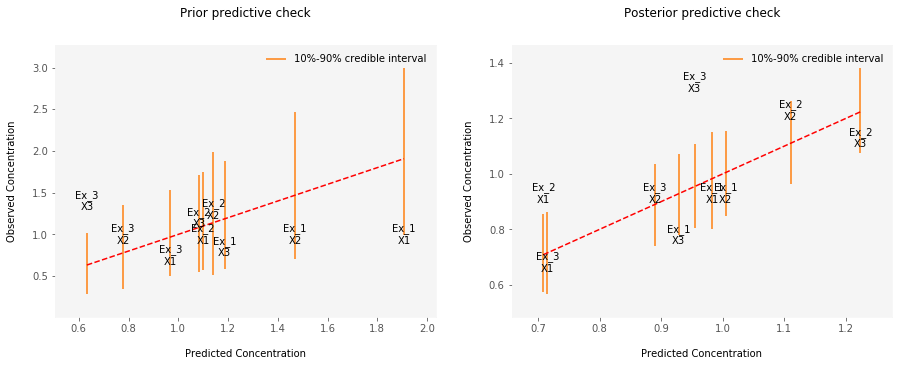

In [12]:
obs = infd.observed_data.to_dataframe()
posterior_pred = infd.posterior_predictive['final_metabolite_concentration_pred'].to_dataframe()
prior_pred = infd.prior_predictive['final_metabolite_concentration_pred'].to_dataframe()

g_posterior = posterior_pred.groupby(['experiments', 'metabolites'])
g_prior =  prior_pred.groupby(['experiments', 'metabolites'])

f, axes = plt.subplots(1, 2, figsize=[15, 5])

for ax, g, name in zip(axes, [g_prior, g_posterior], ['prior', 'posterior']):
    lower = g['final_metabolite_concentration_pred'].quantile(0.1).rename('lower')
    mean = g['final_metabolite_concentration_pred'].mean().rename('mean')
    upper = g['final_metabolite_concentration_pred'].quantile(0.9).rename('upper')
    
    xx = np.linspace(mean.min(), mean.max(), 10)
    vlines = ax.vlines(mean, lower, upper, color='tab:orange', zorder=0, label='10%-90% credible interval')
    y_equals_x_line = ax.plot(xx, xx, color='r', linestyle='--')
    for i, row in obs.iterrows():
        ax.text(mean.loc[i], row, '\n'.join(i), horizontalalignment='center')
    text = ax.set(xlabel='Predicted Concentration', 
                  ylabel='Observed Concentration',
                  title=f'{name.capitalize()} predictive check')
    leg = ax.legend(frameon=False)
    
plt.savefig('output/checks.png')

Metabolite $X_3$ in experiment $Ex_3$ is a clear outlier - the prior distribution expects a somewhat lower concentration, and the observed value is far higher than the posterior distribution expects. This probably indicates a problem somewhere in the system - perhaps the model goes a bit wrong in an undiagnosed way for that experiment, or that measurement was anomolous. It is also possible that this is a sign of an effect that the model was not taking into account, such as inhibition working differently in the specific conditions of experiment 3.

# Conclusion

This analysis method seems to work ok for this simple example, but it probably wouldn't scale that well with a larger number of experiments or a more complex system of reactions. Here are a few things that I think could be improved, making the model faster or better while using roughly the same approach:

- The system of differential equation could perhaps be simplified a bit
- Use Stan's parallelisation features to speed up the sampling.
- Use a more principled method for choosing when the ODE solver's solution should represent a steady state.
- Solve for steady state explicitly rather than using simulations.
- Spend some more time thinking about appropriate priors and measurement accuracies.